In [2]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

In [4]:
# training config:
epochs = 20
batch_size = 32

In [5]:
train_path = 'train'
valid_path = 'test'

In [6]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [8]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(folders)

['train\\Bu_anil', 'train\\Chwi_gajil', 'train\\Eeo_eojosa', 'train\\Ga_olheul', 'train\\Gyeong_byeoseul', 'train\\Ha_alae', 'train\\Ha_eojji', 'train\\Il_han', 'train\\I_sseo', 'train\\Ji_al', 'train\\Ji_gal', 'train\\Mu_eobseul', 'train\\Wi_hal', 'train\\Yu_isseul']


In [ ]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [9]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [10]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [11]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(units=32,activation="relu")(x)
x = Dense(units=32,activation="relu")(x)

In [12]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [14]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:

# tell the model what cost and optimization method to use
# optimizer: RMSprop, Adam
model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [16]:

# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  
  width_shift_range=0.1,
  height_shift_range=0.1,
  zoom_range=0.2,
  horizontal_flip=False,
  vertical_flip=False,
  preprocessing_function=preprocess_input
)

In [17]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 711 images belonging to 14 classes.
{'Bu_anil': 0, 'Chwi_gajil': 1, 'Eeo_eojosa': 2, 'Ga_olheul': 3, 'Gyeong_byeoseul': 4, 'Ha_alae': 5, 'Ha_eojji': 6, 'I_sseo': 7, 'Il_han': 8, 'Ji_al': 9, 'Ji_gal': 10, 'Mu_eobseul': 11, 'Wi_hal': 12, 'Yu_isseul': 13}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -94.462555 max: 151.061


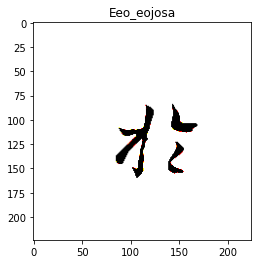

In [18]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [19]:

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 2835 images belonging to 14 classes.


In [20]:

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 711 images belonging to 14 classes.


In [21]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

C:\Users\SeonminKim\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
88/88 [==============================] - 632s 7s/step - loss: 2.7383 - accuracy: 0.2559 - val_loss: 1.3291 - val_accuracy: 0.6051
Epoch 2/20
88/88 [==============================] - 721s 8s/step - loss: 1.1138 - accuracy: 0.6586 - val_loss: 1.0368 - val_accuracy: 0.7088
Epoch 3/20
88/88 [==============================] - 679s 8s/step - loss: 0.7530 - accuracy: 0.7578 - val_loss: 0.9555 - val_accuracy: 0.7330
Epoch 4/20
88/88 [==============================] - 667s 8s/step - loss: 0.6210 - accuracy: 0.7957 - val_loss: 0.8504 - val_accuracy: 0.7571
Epoch 5/20
88/88 [==============================] - 683s 8s/step - loss: 0.4536 - accuracy: 0.8646 - val_loss: 0.7534 - val_accuracy: 0.8011
Epoch 6/20
88/88 [==============================] - 698s 8s/step - loss: 0.3901 - accuracy: 0.8718 - val_loss: 0.6969 - val_accuracy: 0.7969
Epoch 7/20
88/88 [==============================] - 682s 8s/step - loss: 0.3890 - accuracy: 0.8716 - val_loss: 0.7279 - val_accuracy: 0.8082
Epoch 8/20
88

In [22]:
model.save("CursiveScriptCF")

INFO:tensorflow:Assets written to: CursiveScriptCF\assets


In [23]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [24]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 2835
Found 2835 images belonging to 14 classes.
[[261   0   0   1   0   0   0   0   0   0   0   1   1   0]
 [  1 120  11   0   0   3   2   0   0   8   4   0   5   8]
 [  0   0 159   0   0   2   0   0   0   0   0   0   0   1]
 [  0   0   0 185   0   1   3   0   0   0   0   0   0   0]
 [  0   0   0   1 165   1   3   1   0   0   2   0   0   0]
 [  0   2   0   2   0 154   0   0   0   4   0   0   0   0]
 [  0   2   0   0   3   0 158   0   0   0   0   0   2   0]
 [  0   0   1   0   0   0   0 207   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   2 182   0   0   0   0   0]
 [  0   1   1   1   0   1   0   1   0 231   1   0   2   1]
 [  0   0   0   0   0   2   0   0   0   0 181   0   0   3]
 [  8   0   0   0   0   0   1   0   0   1   1 290   0   0]
 [  0   1   1   0   0   0   1   0   0   0   0   0 226   1]
 [  0   6   0   0   0   0   0   0   0   0   1   0  10 192]]


In [25]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 711
Found 711 images belonging to 14 classes.
[[66  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21 10  0  1  1  0  0  0  2  0  0  3  4]
 [ 0  2 38  0  0  0  0  0  0  2  0  0  1  0]
 [ 0  0  0 44  2  1  0  0  0  0  0  0  0  0]
 [ 0  0  1  2 31  0  1  0  0  0  0  4  0  0]
 [ 0  0  0  0  0 37  0  1  3  0  1  0  0  0]
 [ 0  2  0  0  0  0 39  0  0  0  0  0  2  0]
 [ 0  1  1  0  0  1  1 47  0  0  0  0  0  1]
 [ 0  0  0  3  0  2  0  0 39  0  1  0  0  0]
 [ 0  0  3  0  0  0  0  1  0 50  1  0  2  2]
 [ 0  1  0  0  0  3  0  0  3  0 41  0  0  1]
 [10  0  0  1  0  0  0  0  0  1  0 64  0  0]
 [ 1  1  1  0  0  1  0  0  0  0  0  0 51  0]
 [ 2  0  0  1  0  1  0  0  0  0  0  0  6 43]]


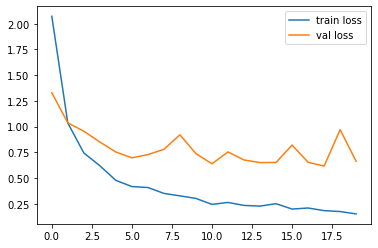

In [26]:
# plot some data

# loss
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

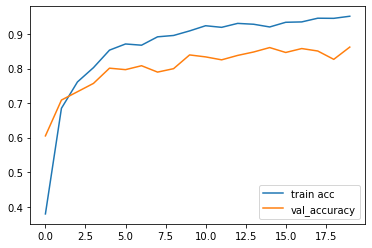

In [27]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()